In [1]:
# Import basic stuffs

import os, sys, re, glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load Basic analytic data for gkmQC paper
# exec(open("../scripts/__scratch__basic_import.py").read())

import pickle

### ENCODE & roadmap info
## All ENCODE metadata
print("Load ENCODE metadata table")
encode_df = pd.read_table("../data/encode_metadata_info_latest.txt", index_col="acc_peak")

# Load sample id sample types dictionary
f = open("../data/sid_stype_dic.pkl", "rb")
sid_stype_dic = pickle.load(f)
f.close()
encode_df.loc[:, "sample_abbr"] = encode_df["acc_sample"].map(sid_stype_dic)

# FRiP
frip_pkl_file = "../data/prefix_frip_dic.pkl"
f = open(frip_pkl_file, "rb")
prefix_frip_dic = pickle.load(f)
f.close()

# IDR
idr_pkl_file = "../data/idr_top10_pval_avg_dic.pkl"
f = open(idr_pkl_file, "rb")
idr_top10_pval_avg_dic = pickle.load(f)
f.close()

analysis_dict_list = list(map(lambda x: prefix_frip_dic[x], ["peaks", "enhancer", "promoter"])) # Three-frip scores
analysis_dict_list += [idr_top10_pval_avg_dic] # IDR
for param, analysis_dict in zip(["FRiP_peak", "FRiP_enhancer", "FRiP_promoter", "IDR_mlog10_avg"], analysis_dict_list):
    encode_df.loc[:,param] = encode_df.index.map(analysis_dict)

## ENTEx tissue info data
print("Load ENTEx tissue-quality mapping")
entex_df = pd.read_table("../data/entx_tissue_info.txt", index_col="fid")

Load ENCODE metadata table
Load ENTEx tissue-quality mapping


# Figure 2: Revisiting ENCODE: quality assessment with gkmQC

Quality parameters of peaks assessed by gkmQC and SPOT2.

In [3]:
import pickle, requests, json
headers = {'accept': 'application/json'}

## SPOT2 scores
spot2_dic_pkl_file = "../data/prefix_spot2_dic.pkl"
f = open(spot2_dic_pkl_file, "rb")
prefix_spot2_dic = pickle.load(f)
f.close()

# Read counts
readc_dic_pkl_file = "../data/prefix_readc_dic.pkl"
f = open(readc_dic_pkl_file, "rb")
prefix_readc_dic = pickle.load(f)
f.close()

# peak count dic
prefix_pcount_dic_pkl = "../data/prefix_pcount_dic.pkl"
f = open(prefix_pcount_dic_pkl, "rb")
prefix_pcount_dic = pickle.load(f)
f.close()
    
# peak specificity
f = open("../data/prefix_ps_dic.pkl", "rb")
prefix_ps_dic = pickle.load(f)
f.close()
    
# dAUC
prefix_dauc_dic_pkl = "../data/prefix_dauc_dic.pkl"
f = open(prefix_dauc_dic_pkl, "rb")
prefix_dauc_dic = pickle.load(f)
f.close()
    
# new gkmQC
# score1 = (1 - auc_min/auc_max) / n
# score2 = (auc_max ** 2 - auc_min ** 2) / n
# score3 = (auc_max - auc_min) / ((auc_max + auc_min) * n)
# score4 = ((auc_max + auc_min) / 2 * n) / (auc_max - auc_min)
# score5 = sum(auc_scores) / (auc_max - auc_min)

prefix_gkmqc_dic_pkl = "../data/prefix_gkmqc_dic.pkl"
f = open(prefix_gkmqc_dic_pkl, "rb")
prefix_gkmqc_dic = pickle.load(f)
f.close()

## 2A
A scatter plot of gkmQC score (dAUC) and SPOT2. 

In [4]:
from scipy.stats import spearmanr
n_param = 4 # = sum(AUC)/(auc_max - auc_min)

l1_spot2 = []
l2_spot2 = []
l1_gkmqc = []
l2_gkmqc = []
l1_m = []
l2_m = []
l1_p = []
l2_p = []
for prefix in prefix_spot2_dic:
    try:
        if np.isnan(prefix_gkmqc_dic[prefix][n_param]):
            continue
    except:
        continue
        
    prefix_type = encode_df.loc[prefix, "sample_type"]
    if prefix_type == 'tissue' or prefix_type == 'primary':
        l1_spot2.append(prefix_spot2_dic[prefix])
        l1_gkmqc.append(prefix_gkmqc_dic[prefix][n_param])
        l1_m.append(prefix_ps_dic[prefix])
        l1_p.append(prefix_pcount_dic[prefix])
    else:
        l2_spot2.append(prefix_spot2_dic[prefix])
        l2_gkmqc.append(prefix_gkmqc_dic[prefix][n_param])
        l2_m.append(prefix_ps_dic[prefix])
        l2_p.append(prefix_pcount_dic[prefix])

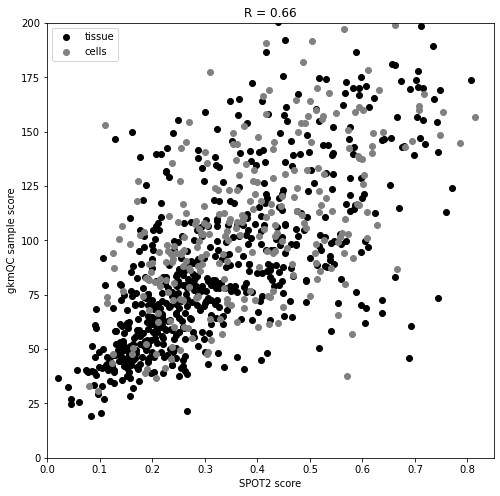

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(l1_spot2, l1_gkmqc, label="tissue", c="black")
plt.scatter(l2_spot2, l2_gkmqc, label="cells", c="grey")
plt.ylim(0, 200)
plt.xlim(0, 0.85)
plt.xlabel("SPOT2 score")
plt.ylabel("gkmQC sample score")
plt.legend()
plt.title("R = %.2f" % abs(spearmanr(l1_spot2 + l2_spot2, l1_gkmqc + l2_gkmqc)[0]))
plt.savefig("../output/Figure_2A.pdf")

#print("Tissue + Cell")
#print(spearmanr(l1_spot2 + l2_spot2, l1_gkmqc + l2_gkmqc))
#print("Tissue only")
#print(spearmanr(l1_spot2, l1_gkmqc))
#print("Cell only")
#print(spearmanr(l2_spot2, l2_gkmqc))

## 2C
The two quality metrics (X-axis; dAUC and SPOT2) are compared to the two parameters (Y-axis; locating precision and the number of peaks) in the scatter plots. The X-axis for dAUC and the Y-axis for the m parameter are reversed so that samples in right-top corners are high-quality samples.

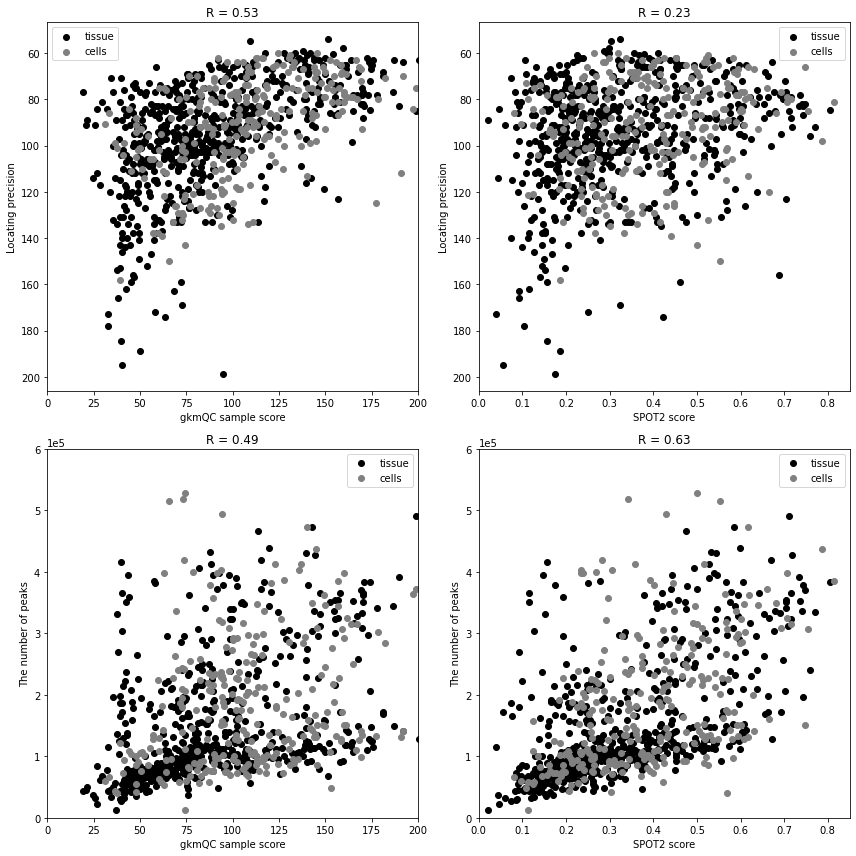

In [9]:
fig, axe = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
l_xlabel = ["gkmQC sample score", "SPOT2 score"]
l_xlim = [(0, 200), (0, 0.85)]
l_ylabel = ["Locating precision", "The number of peaks"]

for i, li_x in enumerate([[l1_gkmqc, l2_gkmqc], [l1_spot2, l2_spot2]]):
    for j, li_y in enumerate([[l1_m, l2_m], [l1_p, l2_p]]):
        
        li_x1, li_x2 = li_x
        li_y1, li_y2 = li_y
        
        plt.sca(axe[j][i])
        plt.scatter(li_x1, li_y1, label="tissue", c="black")
        plt.scatter(li_x2, li_y2, label="cells", c="grey")
        plt.xlim(*l_xlim[i])
        if j == 1:
            plt.ylim(0, 600000)
            plt.ticklabel_format(scilimits=(5, 5), axis="y")
        plt.xlabel(l_xlabel[i])
        plt.ylabel(l_ylabel[j])

        if j == 0:
            plt.gca().invert_yaxis()
        plt.legend()
        plt.title("R = %.2f" % abs(spearmanr(li_x1 + li_x2, li_y1 + li_y2)[0]))
        
        #print(l_xlabel[i] + " - " + l_ylabel[j])
        #print("Tissue + Cell")
        #print(spearmanr(li_x1 + li_x2, li_y1 + li_y2))
        #print("Tissue only")
        #print(spearmanr(li_x1, li_y1))
        #print("Cell only")
        #print(spearmanr(li_x2, li_y2))
plt.tight_layout()
plt.savefig("../output/Figure_2C.pdf")

## S3:
Comparison of two quality parameters (m and |P|). A weak anti-correlation between the mappinglocating precision and the number of peaks demonstrates a trade-off between the two different quality parameters.

Text(0.5, 1.0, 'R = 0.21')

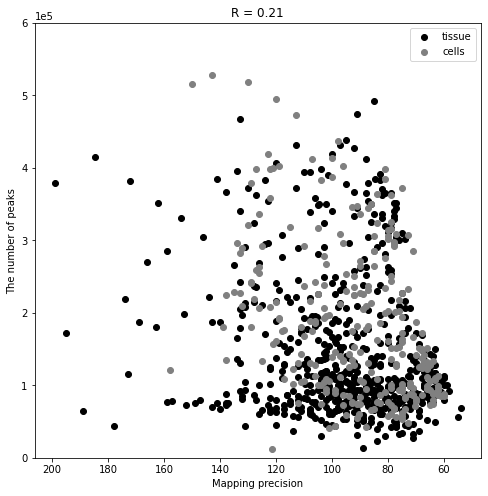

In [41]:
plt.figure(figsize=(8, 8))
plt.scatter(l1_m, l1_p, label="tissue", c="black")
plt.scatter(l2_m, l2_p, label="cells", c="grey")
plt.gca().invert_xaxis()
plt.ylim(0, 600000)
plt.ticklabel_format(scilimits=(5, 5), axis="y")

plt.xlabel("Mapping precision")
plt.ylabel("The number of peaks")
plt.legend()
plt.title("R = %.2f" % abs(spearmanr(l1_m + l2_m, l1_p + l2_p)[0]))

## S4A: Analysis of biological and technical factors affecting quality metrics - Heatmap
shows covariation between several technical factors and quality metrics. Cramer’s V was used to quantify correlations of continuous and discrete variables. Technical factors were not clustered with quality metrics (bold black).

/home/ch218391/program/miniforge3/envs/scatac/lib/python3.7/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


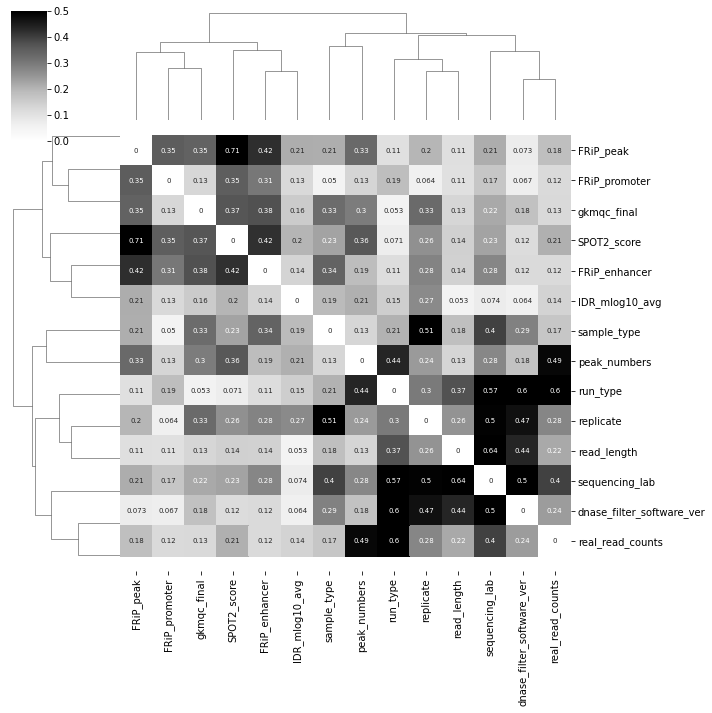

In [4]:
import scipy.stats as ss
import itertools

# Supplementary Figure 1a
## Correlation plot among related parameters

prefix_gf_dic = {}
for prefix in prefix_gkmqc_dic:
    prefix_gf_dic[prefix] = prefix_gkmqc_dic[prefix][4]
    
# peak count dic
add_param_list = ["SPOT2_score", "peak_numbers", "real_read_counts", "gkmqc_final"]
add_dict_list = [prefix_spot2_dic, prefix_pcount_dic, prefix_readc_dic, prefix_gf_dic]
for param, analysis_dict in zip(add_param_list, add_dict_list):
    encode_df.loc[:,param] = encode_df.index.map(analysis_dict)

variables_group = ["replicate", "sample_type", "sequencing_lab", "run_type", "read_length", "dnase_filter_software_ver"]
target_param_list = ["real_read_counts", "peak_numbers", "SPOT2_score", "FRiP_peak", "FRiP_enhancer", "FRiP_promoter", "IDR_mlog10_avg", "gkmqc_final"]

# Additional mapping of gkmQC and other quality-parameters
df = encode_df.copy()

# quantile cut for categorial comparison
for numeric_variable in target_param_list:
    df.loc[:,numeric_variable] = pd.qcut(df[numeric_variable], 5, labels=False)
    
def cramers_corrected_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

cols = variables_group + target_param_list
corrM = np.zeros((len(cols),len(cols)))

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df.loc[:,col1], df.loc[:,col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
r = sns.clustermap(corr, annot=True, cmap="Greys", annot_kws={"size": 7}, vmin=0.0, vmax=0.5, metric="correlation")
b, t = r.ax_heatmap.get_ylim()
b += 0.5
t -= 0.5
dum = r.ax_heatmap.set_ylim(b, t)
plt.savefig("../output/Figure_S4A.pdf")

## S4B - Boxplots
Boxplots show differences in quality metrics (x-axis) for several different technical factors. P-values were calculated with one-way ANOVA of the quality metric scores according to the technical factor.

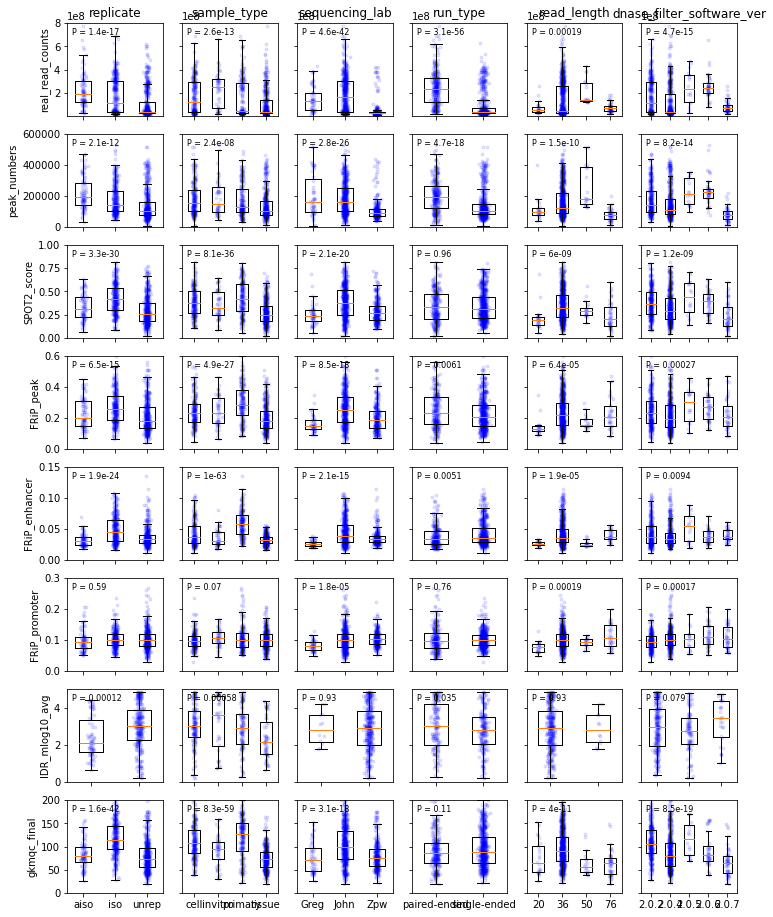

In [13]:
from scipy.stats import f_oneway

def shortage_rep(text):
    if text == 'anisogenic': return "aiso"
    if text == 'isogenic': return "iso"
    if text == 'unreplicated': return "unrep"
    if text == 'john-stamatoyannopoulos': return "John"
    if text == 'gregory-crawford': return 'Greg'
    if text == 'zhiping-weng': return "Zpw"
    if text == 'in': return 'invitro'
    return text

param_lim = {
    "real_read_counts":(10000000, 800000000),
    "FRiP_peak":(0.0, 0.6),
    "FRiP_enhancer":(0.0, 0.15),
    "FRiP_promoter":(0.0, 0.3),
    "IDR_mlog10_avg":(0.0, 5.0),
    "gkmqc_final":(0, 200),
    "SPOT2_score":(0.0, 1.0),
    "peak_numbers":(0, 600000)
}

variables_group = ["replicate", "sample_type", "sequencing_lab", "run_type", "read_length", "dnase_filter_software_ver"]
n_rows = len(target_param_list)
n_cols = len(variables_group)

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(2 * n_cols, 2 * n_rows))
for i, param in enumerate(target_param_list):
    prefix_list = encode_df[np.isfinite(encode_df[param])].index
    df = encode_df.reindex(list(prefix_list))
    for j, variable in enumerate(variables_group):
        groups = df.groupby(variable)
        plt.sca(ax[i][j])
        y_group = []
        n_list = []
        for name, group in groups:
            y = list(df.reindex(group.index)[param])
            if len(y) >= 10:
                y_group.append(y)
                n_list.append(shortage_rep(name))

        for k, y in enumerate(y_group):
            x = np.random.normal(k+1, 0.04, size=len(y))
            plt.plot(x, y, 'b.', alpha=0.1, rasterized=True)
        plt.boxplot(y_group, labels=n_list, showfliers=False, widths=0.5)
        plt.annotate("P = %.2g" % f_oneway(*y_group)[1], xy=(0, 1), fontsize=8, xycoords='axes fraction',\
                     xytext=(5, -5), textcoords='offset points', ha='left', va='top')
        if i != n_rows - 1:
            plt.tick_params(labelbottom=False)
        if j == 0:
            plt.ylabel(param)
        else:
            plt.tick_params(labelleft=False)
        if i == 0: plt.title(variable)
        #if i == 0: plt.legend(loc=2)
        #if param == 'gkmqc_final':
        #    plt.yscale("log", basey=10)
        plt.ylim(param_lim[param])
#plt.tight_layout()
#plt.show()
plt.savefig("../output/Figure_S4B.pdf")

## S5 - Validation of sample quality for autopsy tissues in the ENTEx dataset.
All ENTEx autopsy samples are divided into two groups, high- (HQ), and low-quality (LQ) sets, based on dAUC (top) and SPOT2 (bottom), separately. For each group, durations of postmortem time from cardiac cessation to freezing of the sample are compared between HQ and LQ samples, and the statistical significances of the differences were tested with the Mann-Whitney U Test. Based on dAUC < 0.015, high-quality samples show the most significant difference in the duration of postmortem time (P <0.05).

In [6]:
# Load ENTEx tissue-quality mapping
entex_df = pd.read_table("../data/entx_tissue_info.txt", index_col="fid")
for param, analysis_dict in zip(["SPOT2", "gkmQC"], [prefix_spot2_dic, prefix_gf_dic]):
    entex_df.loc[:,param] = entex_df.index.map(analysis_dict)

In [8]:
x1 = list(entex_df["gkmQC"]) # gkmQC
x2 = list(entex_df["SPOT2"]) # SPOT2
y  = list(entex_df["time_interval"]) # time interval

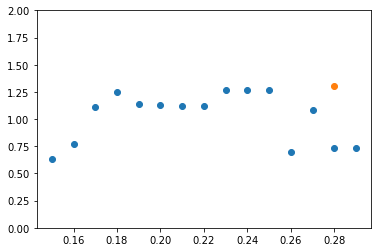

In [22]:
from scipy.stats import mannwhitneyu
xl = []
yl = []
xy_list = list(zip(x2, y))
for cutoff in np.array(list(range(15, 30))) * 0.01:
    hq_ti = list(map(lambda x: x[1], list(filter(lambda x: x[0] >= cutoff, xy_list))))
    lq_ti = list(map(lambda x: x[1], list(filter(lambda x: x[0] < cutoff, xy_list))))
    if len(hq_ti) > 3 and len(lq_ti) > 3:
        xl.append(cutoff)
        yl.append(-1.0 * np.log10(mannwhitneyu(hq_ti, lq_ti, alternative="less")[1]))
scatter(xl, yl)
scatter([0.28], [-1.0 * np.log10(0.05)])
ylim(0, 2.0)
plt.savefig("../output/Figure_S2D_SPOT2.pdf")

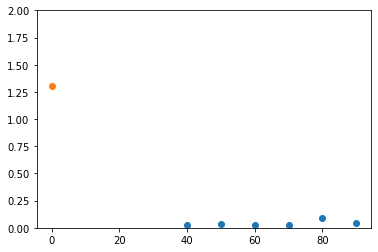

In [23]:
xl = []
yl = []
xy_list = list(zip(x1, y))
for cutoff in np.array(list(range(1, 10))) * 10:
    hq_ti = list(map(lambda x: x[1], list(filter(lambda x: x[0] >= cutoff, xy_list))))
    lq_ti = list(map(lambda x: x[1], list(filter(lambda x: x[0] < cutoff, xy_list))))
    if len(hq_ti) > 3 and len(lq_ti) > 3:
        xl.append(cutoff)
        yl.append(-1.0 * np.log10(mannwhitneyu(hq_ti, lq_ti, alternative="greater")[1]))
scatter(xl, yl)
scatter([0.018], [-1.0 * np.log10(0.05)])
ylim(0, 2.0)
plt.savefig("../output/Figure_S2D_gkmqc.pdf")

SpearmanrResult(correlation=-0.2274659300392659, pvalue=0.09809136353718163)


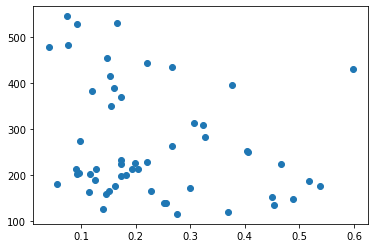

In [12]:
scatter(x2, y)
from scipy.stats import spearmanr
print(spearmanr(x2, y))

SpearmanrResult(correlation=-0.243052644323192, pvalue=0.07657156286919002)


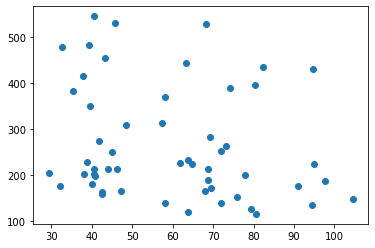

In [13]:
scatter(x1, y)
from scipy.stats import spearmanr
print(spearmanr(x1, y))

SpearmanrResult(correlation=-0.44291651254398723, pvalue=0.12958349612959383)
SpearmanrResult(correlation=-0.33516483516483514, pvalue=0.2629431403593601)
SpearmanrResult(correlation=-0.2003097840506941, pvalue=0.4254752598253613)
SpearmanrResult(correlation=-0.4787878787878787, pvalue=0.1615229280174558)


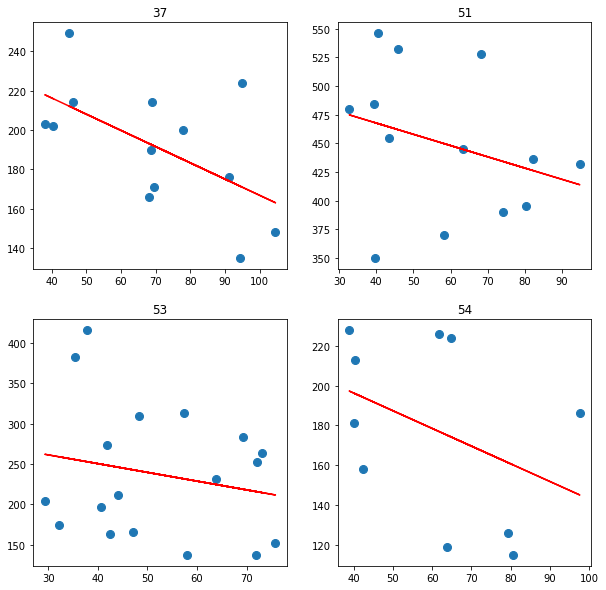

In [18]:
#from scipy.stats import pearsonr
#import seaborn as sns

groups = entex_df.groupby('age')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
n = 0
for name, group in groups:
    if len(group.gkmQC) > 1:
        i = int(n / 2)
        j = n % 2
        plt.sca(ax[i][j])
        plt.plot(group.gkmQC, group.time_interval, marker='o', linestyle='', ms=8)
        coef = np.polyfit(group.gkmQC, group.time_interval, 1)
        poly1d_fn = np.poly1d(coef)
        plt.plot(group.gkmQC, poly1d_fn(group.gkmQC), color='red')
        plt.title(name)
        n += 1
        print(spearmanr(group.gkmQC, group.time_interval))
#ax.legend()
#plt.savefig("corr_gkmqc_tissue_wise_analysis.pdf")

SpearmanrResult(correlation=-0.40990410167114344, pvalue=0.16420798385248878)
SpearmanrResult(correlation=-0.5384615384615384, pvalue=0.057634433470466075)
SpearmanrResult(correlation=-0.04749613436253572, pvalue=0.851545240773077)
SpearmanrResult(correlation=0.01818181818181818, pvalue=0.9602404181286243)


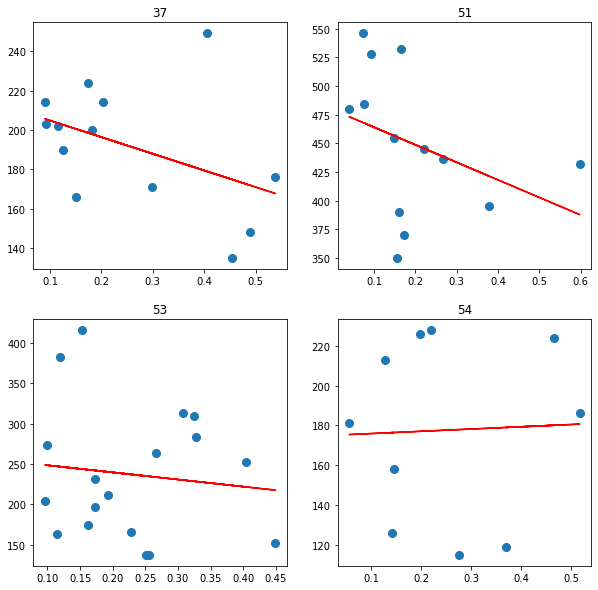

In [19]:
#from scipy.stats import pearsonr
#import seaborn as sns

groups = entex_df.groupby('age')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
n = 0
for name, group in groups:
    if len(group.SPOT2) > 1:
        i = int(n / 2)
        j = n % 2
        plt.sca(ax[i][j])
        plt.plot(group.SPOT2, group.time_interval, marker='o', linestyle='', ms=8)
        coef = np.polyfit(group.SPOT2, group.time_interval, 1)
        poly1d_fn = np.poly1d(coef)
        plt.plot(group.SPOT2, poly1d_fn(group.SPOT2), color='red')
        plt.title(name)
        n += 1
        print(spearmanr(group.SPOT2, group.time_interval))
#ax.legend()
#plt.savefig("corr_gkmqc_tissue_wise_analysis.pdf")

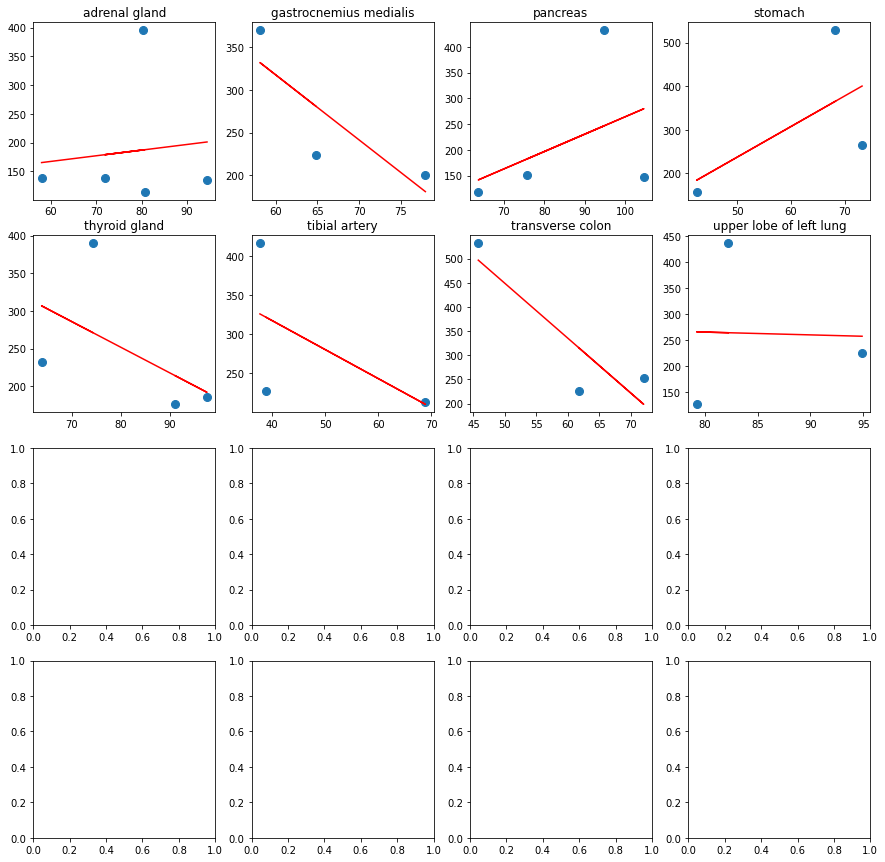

In [21]:
#from scipy.stats import pearsonr
#import seaborn as sns

groups = entex_df.groupby('desc')
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
n = 0
for name, group in groups:
    if len(group.gkmQC) > 2:
        i = int(n / 4)
        j = n % 4
        plt.sca(ax[i][j])
        plt.plot(group.gkmQC, group.time_interval, marker='o', linestyle='', ms=8)
        coef = np.polyfit(group.gkmQC, group.time_interval, 1)
        poly1d_fn = np.poly1d(coef)
        plt.plot(group.gkmQC, poly1d_fn(group.gkmQC), color='red')
        plt.title(name)
        n += 1
#plt.savefig("corr_gkmqc_tissue_wise_analysis.pdf")